# Traffic Signs detection for TensorFlow Lite

This notebook shows how to train simple classification TensorFlow Lite model for traffic signs detection. We'll use retraining techniques on top of MobileNet v1 convolutional neural network. Like in the other project in the series - [MNIST for TFLite](https://github.com/frogermcs/MNIST-TFLite), we'll focus more on how to plugin and utilize the model on mobile app than on training high accuracy deep learning network.

Inspiration for this project comes from two entry-level codelabs **TensorFlow For Poets**:

[TensorFlow For Poets](https://codelabs.developers.google.com/codelabs/tensorflow-for-poets/index.html#0)  
[TensorFlow For Poets 2 - TFLite Android](https://codelabs.developers.google.com/codelabs/tensorflow-for-poets-2-tflite/index.html)

In fact, some parts of code here are just copy and paste of solutions described in those two articles. If you haven't done it yet, I highly recommend to start from reading and implementing of what's described there.

## Prerequisites

Add **TensorFlow Hub** dependency. This is the place where you can find pretrained, reusable Machine Learning components, like MobileNet and others. For more information, visit the [TensorFlow Hub website](https://www.tensorflow.org/hub).

In [2]:
!pip install tensorflow_hub


In [3]:
from PIL import Image
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import tensorflow_hub as hub
from tensorflow.keras import layers
import pandas as pd
from sklearn.metrics import accuracy_score

### Output configuration

Directories where we'll store notebook output - TensorFlow Lite model and labels for classification.

In [4]:
OUTPUT_ROOT_DIR = "output/"
OUTPUT_TFLITE_MODEL = os.path.join(OUTPUT_ROOT_DIR, "retrained_graph_mv1_100_224.tflite")
OUTPUT_LABELS = os.path.join(OUTPUT_ROOT_DIR, "retrained_labels_mv1_100_224.txt")
OUTPUT_READABLE_LABELS = os.path.join(OUTPUT_ROOT_DIR, "labels_readable.txt")

### Model configuration

Model input configuration comes from MobileNet network that we selected. Here we picked the one that has input image size 224x224 (you can see it in the url name). Other possible values of MobileNet v1: 192, 160, 128. The lower input value is, the faster model, but of course speed improvement isn't for free - smaller input size also results with worse accuracy (see more in the [blog post](https://ai.googleblog.com/2017/06/mobilenets-open-source-models-for.html)).

Mean and Std values are specific for MobileNet networks, and can be different from the others like Inception.

For more information, just visit url presented below.

In [5]:
SELECTED_MOBILENET = "https://tfhub.dev/google/imagenet/mobilenet_v1_100_224/feature_vector/4"

IMAGE_SHAPE = (224, 224)

MODEL_INPUT_HEIGHT = 224
MODEL_INPUT_WIDTH = 224
MODEL_INPUT_MEAN = 0
MODEL_INPUT_STD = 255

#Input layer of MobileNet v1 has constant name called "Placeholder"
MODEL_INPUT_LAYER_NAME = "Placeholder"
#Output layer can be defined by us, default one is "final_result"
MODEL_OUTPUT_LAYER_NAME = "final_result"

## Dataset

Our dataset comes from **GTSRB** - The German Traffic Sign Recognition Benchmark ([website](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset), [kaggle](https://www.kaggle.com/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign)). It contains more than 40 classes and more than 50,000 images of traffic signs, which are prepared for multi-class, single-image classification challenge. Base on it we'll build simple classifier that can be used in mobile application (or any other TensorFlow Lite project).

In [6]:
TMP_DATA_DIR = "dataset/tmp"
TMP_LABELS_DIR = os.path.join(TMP_DATA_DIR, "GTSRB/Final_Test")

TRAINING_DATA_DIR = "dataset/training"
VALIDATION_DATA_DIR = "dataset/validation"

In [7]:
#Fetch images deom GTSRB website
#Images for training
!curl -LOC - https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
#Images for validation
!curl -LOC - https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_Images.zip
#Labels for validation
!curl -LOC - https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_GT.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  263M  100  263M    0     0   187M      0  0:00:01  0:00:01 --:--:--  187M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 84.8M  100 84.8M    0     0   159M      0 --:--:-- --:--:-- --:--:--  159M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 99620  100 99620    0     0   695k      0 --:--:-- --:--:-- --:--:--  699k


In [8]:
%%time
to_unpack = [
    ("GTSRB_Final_Training_Images.zip", TMP_DATA_DIR),
    ("GTSRB_Final_Test_Images.zip", TMP_DATA_DIR),
    ("GTSRB_Final_Test_GT.zip", TMP_LABELS_DIR)
]

for file, directory in to_unpack:
    print("Unzipping {} to {}...".format(file, directory))
    with zipfile.ZipFile(file,"r") as zip_ref:
        zip_ref.extractall(directory)

Unzipping GTSRB_Final_Training_Images.zip to dataset/tmp...
Unzipping GTSRB_Final_Test_Images.zip to dataset/tmp...
Unzipping GTSRB_Final_Test_GT.zip to dataset/tmp/GTSRB/Final_Test...
CPU times: user 5.91 s, sys: 2.28 s, total: 8.19 s
Wall time: 8.2 s


### Prepare training, validation and labels

#### Labels

Originally dataset operates on numerical labels (e.g. "00000"). Let's make it human-readable.  
Labels will be saved in `/output` directory - they can be used together with final TensorFlow Lite model.

In [9]:
label_map = {
    0: '20_speed',
    1: '30_speed',
    2: '50_speed',
    3: '60_speed',
    4: '70_speed',
    5: '80_speed',
    6: '80_lifted',
    7: '100_speed',
    8: '120_speed',
    9: 'no_overtaking_general',
    10: 'no_overtaking_trucks',
    11: 'right_of_way_crossing',
    12: 'right_of_way_general',
    13: 'give_way',
    14: 'stop',
    15: 'no_way_general',
    16: 'no_way_trucks',
    17: 'no_way_one_way',
    18: 'attention_general',
    19: 'attention_left_turn',
    20: 'attention_right_turn',
    21: 'attention_curvy',
    22: 'attention_bumpers',
    23: 'attention_slippery',
    24: 'attention_bottleneck',
    25: 'attention_construction',
    26: 'attention_traffic_light',
    27: 'attention_pedestrian',
    28: 'attention_children',
    29: 'attention_bikes',
    30: 'attention_snowflake',
    31: 'attention_deer',
    32: 'lifted_general',
    33: 'turn_right',
    34: 'turn_left',
    35: 'turn_straight',
    36: 'turn_straight_right',
    37: 'turn_straight_left',
    38: 'turn_right_down',
    39: 'turn_left_down',
    40: 'turn_circle',
    41: 'lifted_no_overtaking_general',
    42: 'lifted_no_overtaking_trucks'
}

if not os.path.exists(OUTPUT_ROOT_DIR):
        os.makedirs(OUTPUT_ROOT_DIR)

file = open(OUTPUT_READABLE_LABELS, 'w')
for key, val in sorted(label_map.items()):
    file.write("{}\n".format(val))
file.close()



#### Training dataset preparation

The only tricky part of GTSRB dataset is that images are stored as [*.ppm](https://en.wikipedia.org/wiki/Netpbm_format) files, which aren't supported by TensorFlow by default. To make it possible we need to convert them to .jpg files.

In [10]:
# Collect all PPM files and their labels

tmp_train_data_dir = os.path.join(TMP_DATA_DIR, "GTSRB/Final_Training/Images")

# Get all subdirectories of data_dir. Each represents a label.
directories = [d for d in os.listdir(tmp_train_data_dir)
               if os.path.isdir(os.path.join(tmp_train_data_dir, d))]
# Loop through the label directories and collect the data in two lists, labels and images.
ppm_files_train = []
ppm_labels_train = []
for class_directory in directories:
    label_dir = os.path.join(tmp_train_data_dir, class_directory)
    file_names = [os.path.join(label_dir, f)
                  for f in os.listdir(label_dir) if f.endswith(".ppm")]
    # For each label, load it's images and add them to the images list.
    # And add the label number (i.e. directory name) to the labels list.
    for image_file in file_names:
        ppm_files_train.append(image_file)
        ppm_labels_train.append(class_directory)

# Let's have it sorted for better debugging.
ppm_files_train.sort()
ppm_labels_train.sort()

In [11]:
%%time
# Convert
# from: dataset/Final_Training/Images/00000/00000_00000.ppm
# to:   dataset/training/00000/00000_00000.jpg

for ppm_file, label in zip(ppm_files_train, ppm_labels_train):
    image = Image.open(ppm_file)
    directory = os.path.join(TRAINING_DATA_DIR, label)
    image_filename = "{}.jpg".format(os.path.splitext(os.path.basename(ppm_file))[0])

    if not os.path.exists(directory):
        os.makedirs(directory)

    image.save(os.path.join(directory, image_filename))

CPU times: user 5.21 s, sys: 2.2 s, total: 7.4 s
Wall time: 7.43 s


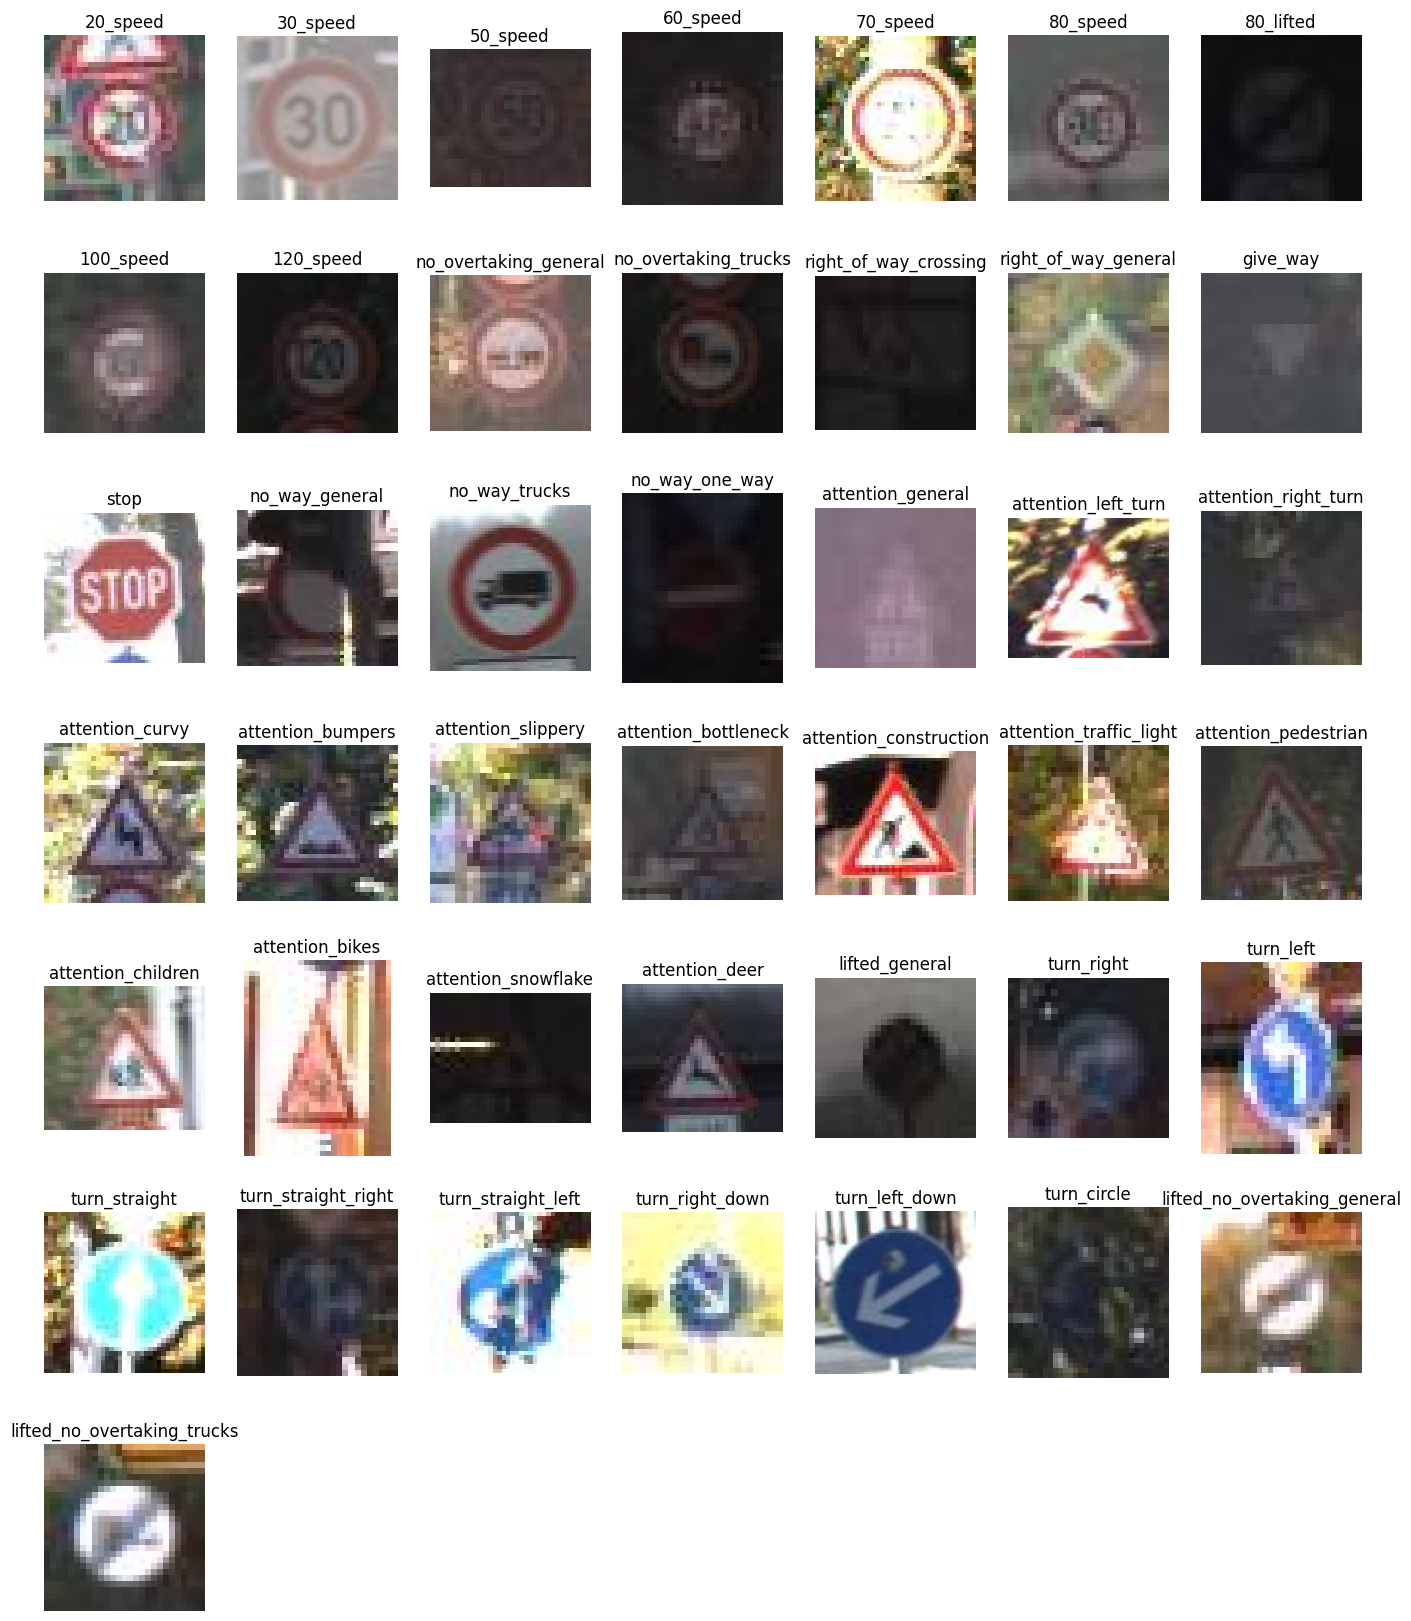

In [12]:
# Print all categories with example image for each of them.
preprocessed_training_dirs = [d for d in os.listdir(TRAINING_DATA_DIR)
               if os.path.isdir(os.path.join(TRAINING_DATA_DIR, d))]
preprocessed_training_dirs.sort()

training_images = []
for training_dir in preprocessed_training_dirs:
    training_images.append(os.path.join(TRAINING_DATA_DIR, training_dir, "00000_00000.jpg"))

i = 0
plt.figure(figsize=(17, 30))
for image in training_images:
    plt.subplot(10,7, i + 1)
    plt.axis('off')
    plt.title("{}".format(label_map[i]))
    i += 1
    plt.imshow(Image.open(image))
plt.show()

All of TensorFlow Hub's image modules expect float inputs in the `[0, 1]` range. Use the `ImageDataGenerator`'s `rescale` parameter to achieve this.

The image size will be handled later.





In [13]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data = image_generator.flow_from_directory(str(TRAINING_DATA_DIR), target_size=IMAGE_SHAPE)

Found 39209 images belonging to 43 classes.


The resulting object is an iterator that returns image_batch, label_batch pairs.

In [14]:
for image_batch, label_batch in image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Label batch shape: ", label_batch.shape)
  break

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 43)


#### Validation dataset preparation

Convert also the validation dataset from *.ppm to *.jpg

In [15]:
#Load testing set
tmp_validation_data_dir = os.path.join(TMP_DATA_DIR, "GTSRB/Final_Test/Images")

In [16]:
%%time

tmp_validation_data_files = [f for f in os.listdir(tmp_validation_data_dir) if f.endswith(".ppm")]
validation_images = []

#export as JPGs
for ppm_file in tmp_validation_data_files:
    image_dir = os.path.join(tmp_validation_data_dir, ppm_file)
    image = Image.open(image_dir)
    directory = VALIDATION_DATA_DIR
    image_filename = "{}.jpg".format(os.path.splitext(os.path.basename(ppm_file))[0])

    if not os.path.exists(directory):
        os.makedirs(directory)

    final_image = os.path.join(directory, image_filename)
    image.save(final_image)

    validation_images.append(final_image)
    validation_images.sort()

print("Validation images count:", len(validation_images))

Validation images count: 12630
CPU times: user 2.51 s, sys: 717 ms, total: 3.22 s
Wall time: 3.22 s


## Training

### Create Model

Download a headless model

In [17]:
feature_extractor_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4" #@param {type:"string"}
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(224,224,3))

feature_batch = feature_extractor_layer(image_batch)

print(feature_batch.shape)

(32, 1280)


Freeze the variables in the feature extractor layer, so that the training only modifies the new classifier layer.

In [18]:
feature_extractor_layer.trainable = False

*Attach* a classification head

In [19]:
# Check your versions
print(tf.__version__)
print(hub.__version__)

2.18.0
0.16.1


In [20]:
import tensorflow as tf
import tensorflow_hub as hub

from tensorflow.keras.applications import MobileNetV2

# Create the base model from MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the base model

# Create the Sequential model
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(image_data.num_classes)
])

# Now the model should show the correct parameters
model.summary()

model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 43)             │        55,083 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,313,067 (8.82 MB)

 Trainable params: 55,083 (215.17 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 43)             │        55,083 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,313,067 (8.82 MB)

 Trainable params: 55,083 (215.17 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [21]:
predictions = model(image_batch)

In [22]:
predictions.shape

TensorShape([32, 43])

### Start training process

Use compile to configure the training process:

In [23]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

In [24]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()

Start training the network (Hint: In Google Colab use a GPU hardware acceleration for a faster training)

In [ ]:
steps_per_epoch = int(np.ceil(image_data.samples/image_data.batch_size))

batch_stats_callback = CollectBatchStats()

history = model.fit(image_data, epochs=100,
                    steps_per_epoch=steps_per_epoch,
                    callbacks=[batch_stats_callback])

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1226/1226 ━━━━━━━━━━━━━━━━━━━━ 333s 269ms/step - acc: 0.6076 - loss: 1.3696
Epoch 2/100
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 327s 267ms/step - acc: 0.7706 - loss: 0.7782
Epoch 3/100
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 327s 267ms/step - acc: 0.8172 - loss: 0.6153
Epoch 4/100
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 387s 271ms/step - acc: 0.8453 - loss: 0.5206
Epoch 5/100
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 330s 269ms/step - acc: 0.8641 - loss: 0.4567
Epoch 6/100
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 333s 272ms/step - acc: 0.8765 - loss: 0.4081
Epoch 7/100
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 332s 271ms/step - acc: 0.8882 - loss: 0.3710
Epoch 8/100
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 331s 270ms/step - acc: 0.8969 - loss: 0.3418
Epoch 9/100
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 328s 268ms/step - acc: 0.9052 - loss: 0.3179
Epoch 10/100
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 325s 265ms/step - acc: 0.9114 - loss: 0.2959
Epoch 11/100
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 324s 264ms/step - acc: 0.9172 - loss: 0.2781
Epoch 12/100
1226/1226 ━━━━━━━━━━━━━━━━━━━

Now after, even just a few training iterations, we can already see that the model is making progress on the task.

In [ ]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

In [ ]:
plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)

## Model Evaluation



### Transformation of the evaluation dataset

Load the validation data from the CSV file into a pandas data frame.
Also change the file ending from *.ppm to *.jpg in the `Filename` column.
Then also rescale the values for the model.
The `ClassId` must be a string and with leading zeros, because this classification naming was also used for the subfolders in the training dataset.

In [ ]:
tmp_validation_labels_csv = os.path.join(TMP_LABELS_DIR, "GT-final_test.csv")
val_data_frame = pd.read_csv(tmp_validation_labels_csv, header=0, sep=';')
val_data_frame['Filename'] = val_data_frame['Filename'].str.replace('.ppm','.jpg')
val_data_frame['ClassId'] = val_data_frame['ClassId'].astype(str).str.zfill(5)

image_val_data = image_generator.flow_from_dataframe(val_data_frame, x_col="Filename", directory=VALIDATION_DATA_DIR, y_col="ClassId", target_size=IMAGE_SHAPE)

In [ ]:
for image_val_batch, label_val_batch in image_val_data:
  print("Image batch shape: ", image_val_batch.shape)
  print("Label batch shape: ", label_val_batch.shape)
  break

### Display some predition result


Run one image batch through the model and extract the predicted traffic sign ID.


In [ ]:
predicted_batch = model.predict(image_val_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
label_id = np.argmax(label_val_batch, axis=-1)

Display the images in one batch with the prediction result.
Print the accuracy for the displayed batch.

In [ ]:
batch_size = image_val_batch.shape[0]
num_plot_column = 5
num_plot_row = batch_size // num_plot_column + (batch_size % num_plot_column > 0)

plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(batch_size):
  plt.subplot(num_plot_row,num_plot_column,n+1)
  plt.imshow(image_val_batch[n])
  color = "green" if predicted_id[n] == label_id[n] else "red"
  plt.title(label_map[predicted_id[n]].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

print("Accuracy of the shown eval batch:")
accuracy_score(label_id, predicted_id)

### Calculate validation dataset metrics

Calculate the prediction accuracy and loss for all images in the validation dataset

In [ ]:
score = model.evaluate(x=image_val_data, batch_size=image_val_data.batch_size, steps=image_val_data.samples/image_val_data.batch_size)
print("Loss: ", score[0], "Accuracy: ", score[1])


## Save the trained model

In [ ]:
import time
t = time.time()

export_path = "OUTPUT_ROOT_DIR/model{}".format(int(t))
model.save(export_path, save_format='tf')

export_path

Convert to tensorflow lite model

In [ ]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TF Lite model.
with tf.io.gfile.GFile(OUTPUT_TFLITE_MODEL, 'wb') as f:
  f.write(tflite_model)

### TensorFlow Lite model evaluation

Make sure our TF Lite model is still working after the conversion.

In [ ]:
# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path=OUTPUT_TFLITE_MODEL)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

batch_size = image_val_batch.shape[0]
predicted_id = np.zeros(batch_size)

for i, image in enumerate(np.split(image_val_batch, batch_size)):
  interpreter.set_tensor(input_details[0]['index'], image)
  interpreter.invoke()
  output_data = interpreter.get_tensor(output_details[0]['index'])
  predicted_id[i] = np.argmax(output_data)

label_id = np.argmax(label_val_batch, axis=-1)

num_plot_column = 5
num_plot_row = batch_size // num_plot_column + (batch_size % num_plot_column > 0)

plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(batch_size):
  plt.subplot(num_plot_row,num_plot_column,n+1)
  plt.imshow(image_val_batch[n])
  color = "green" if predicted_id[n] == label_id[n] else "red"
  plt.title(label_map[predicted_id[n]].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")


print("Accuracy of the shown eval batch, with the TensorFlow Lite model:")
accuracy_score(label_id, predicted_id)